### This program outlines a series of steps taken for producing a predicted concentration value from the proto2 sensor

## First step is to load in all of our necessary modules. 
### Pandas and numpy do most of the heavy lifting in this script. Matplotlib is mainly for plotting

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from datetime import datetime, timedelta, date
from matplotlib.path import Path
import matplotlib.patheffects as pe
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys


import warnings
warnings.filterwarnings("ignore")

## Next we'll call in our function that handles the concentration regression. 
### This file is stored at /data/aq/scripts/functions.py

In [2]:
#get the corrected proto2 filenames

#path_corrected_proto2='/data/aq/inhouse/corrected/csv/'
#path_corrected_proto2='corrected-Sept-Modified/'
path_corrected_proto2='despiked_proto2/'

proto2_corrected_filepaths=[]
for file in sorted(os.listdir(path_corrected_proto2)):
    if file != '.ipynb_checkpoints':
        proto2_corrected_filepaths.append(path_corrected_proto2+file)
    
proto2_corrected_from_files=(pd.read_csv(f,on_bad_lines='skip') for f in proto2_corrected_filepaths)
proto2_corrected=pd.concat(proto2_corrected_from_files)

times=pd.to_datetime(proto2_corrected['Unnamed: 0'],format='%Y-%m-%d %H:%M:%S')
proto2_corrected=proto2_corrected.set_index(times)
proto2_corrected.index.names=['date']
proto2_corrected=proto2_corrected.drop('Unnamed: 0',1)
proto2_corrected;

### Resampling the high frequency proto2 data into hour averages so that it's compatible with hourly observations

In [3]:
#take high frequency proto2 data and resample to hourly mean
houravg=proto2_corrected.drop(columns=['datetimestamp']).apply(pd.to_numeric).resample('60min').mean()

### Pulling in observed gas concentrations from DEC. This was acquired using the EPA API

In [4]:
#get the epa filenames

path_epa='/data/aq/DEC/csv/'

epa_filepaths=[]
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)

In [5]:
epa_from_files=(pd.read_csv(f) for f in epa_filepaths)
epa_df=pd.concat(epa_from_files)
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))

### Define some dictionaries that tie the concentration number code to its appropriate name

In [6]:
#set dictionary that matches varid to field name
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}
epa_table={42101:'Trace CO (ppb)',44201:'O3 (ppb)',42601:'NOx (ppb)',42602:'NO2 (ppb)',88101:'PM25FEM (ug/m3)'}

### Toss out times in the DEC observations where there is no recorded data in proto2

In [7]:
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;

### Now prepare the input data and perform the regression

In [8]:
# Select date ranges corresponding to months 
july = (epa_df_matching_proto2['date'] >= '2021-07-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-07-31 23:00:00') 
august = (epa_df_matching_proto2['date'] >= '2021-08-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-08-31 23:00:00') 
september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
october = (epa_df_matching_proto2['date'] >= '2021-10-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-10-31 23:00:00') 
november = (epa_df_matching_proto2['date'] >= '2021-11-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-11-31 23:00:00') 

## Apply Regression

### Generate regression coefficients script 

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from datetime import datetime, timedelta, date

import statsmodels.api as sm
from scipy import stats
import statistics

import warnings
warnings.filterwarnings("ignore")

def generate_coefficients(training_predictors, training_reference_concentrations, method):
    '''
    INPUT...
    training_predictors = list of dataframe corresponding of predictors in training period 
    training_reference_concentrations = dataframe containing reference concentrations (DEC) during training period
    
    method = 'linear' or 'quadratic' (only LINEAR works as of 02/08/2023)    
    ===========================================================
    RETURNS...
    00 = coefficient + y-intercepts of regression equation as a dictionary
    01 = model (kept for documentation purposes)
    '''
    training_predictor_fields=pd.concat(training_data,axis=1)    
    training_sensor_field=training_reference_concentrations
    
    if method == 'linear':
        # apply regression
        reg = LinearRegression()
        model = reg.fit(training_predictor_fields.values, training_sensor_field.values)
        
        # coefficient dictionary
        coefs=model.coef_
        coef_dict={}
        for num_of_coefs in range(len(model.coef_)):
            coef_dict[str(num_of_coefs).zfill(2)]=coefs[num_of_coefs]
        coef_dict['intercept']=model.intercept_
    
    # QUADRATIC IS UNFINISHED 
    if method == 'quadratic':
        # apply regression
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly_features = poly.fit_transform(training_predictor_fields.reshape(-1,10))
        poly_reg_model = LinearRegression()

        model = poly_reg_model.fit(training_predictor_fields.values, training_sensor_field.values)
        
        # coefficient dictionary
        coefs=reg.coef_
        coef_dict={}
        for num_of_coefs in range(len(reg.coef_)):
            coef_dict[str(num_of_coefs).zfill(2)]=coefs[num_of_coefs]
        coef_dict['intercept']=reg.intercept_


    return coef_dict,model

### Calibrate script

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from datetime import datetime, timedelta, date

import statsmodels.api as sm
from scipy import stats
import statistics

import warnings
warnings.filterwarnings("ignore")

def calibrate(coef_dict,testing_predictors, testing_reference_concentrations):
    '''
    INPUT...
    coef_dict = coefficient dictionary returned from generate_coefficients function
    testing_predictors = list of dataframe corresponding of predictors in testing period 
    testing_reference_concentrations = dataframe containing reference concentrations (DEC) during testing period
        
    ===========================================================
    RETURNS...
    00 = calibrated data as an array 
    01 = performance metrics aka stats 
          --> r-squared 
          --> m and slope from fitting the reference data (x) against the calibrated data (y)
          --> RMSE using sklearn module
          --> z-score mean and array 
          --> still need to add: % bias, t-test, and p-value 
    '''
    intercept = model[0]['intercept'] 
    del model[0]['intercept']
    
    #print('\nIntercept = ', intercept)

    calibrated_data = intercept 

    for coefficients in range(len(model[0])):
        if coefficients < 10: 
            coefficient = model[0]['0'+str(coefficients)] # access each coefficient
        else:        
            coefficient = model[0][str(coefficients)] # access each coefficient
    
        #print('Calibrating w/ coefficient = ',testing_predictors[coefficients].name)
        #print('  ... value of coefficient = ',coefficient)
            
        calibrated_data += coefficient*testing_predictors[coefficients] # recursive function
    
    model[0]['intercept'] = intercept
    
    # generate statisitics 
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1) 
    z_score_array = np.array((calibrated_data-calibrated_data.mean())/statistics.stdev(calibrated_data))
            
    stats_dict={} 
    stats_dict['r2'] = r2_score(testing_reference_concentrations,calibrated_data)
    stats_dict['m'] = m[0]
    stats_dict['m_y-int'] = m[1]
    stats_dict['RMSE'] = sqrt(mean_squared_error(calibrated_data, testing_reference_concentrations)) 
    stats_dict['z-score_mean'] = z_score_array.mean()
    stats_dict['z-score_array'] = z_score_array
    
    #print('\n')
    return calibrated_data, stats_dict

### Test with JUST CO

In [52]:
#the observed concentrations and proto2 data are using different timezones. apply a 5 hour fix to shift them over
#long term it may be wise to just correct proto2 data and rewrite it as a file
tshift=5

method='linear'

for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:

    #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
    if var_id==44201:
        epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
        epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)

    else:
        epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
        epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)

    #combine the observations and proto2 data into one dataset
    combined_df=pd.concat([epa_concentration_field,houravg],axis=1).dropna()

    #include some checks to see if the field is O3 or pm2.5
    #O3 needs to subtract NO2 because the sensor only records O3NO2
    #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
    #basically we're just calculating the voltage difference here
    if var_id==44201:
        combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
        gname='O3'
        unit = '_ppb'
        pltunit = 'ppb'

    elif var_id in [88101]:
        gname='pm25'
        combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
        unit='_env_ugm3'
        pltunit = 'ug/m³'

    else:
        fname=proto2_table[str(var_id)]
        gname_loc=fname.find('ppb')-1
        gname=fname[:gname_loc]

        combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
        unit = '_ppb'
        pltunit = 'ppb'


    #perform some additional last minute qc on the data
    #this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
    combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                         & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                         & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
    # some fun time predictors 
    combined_df_filtered['decimal_day'] = combined_df_filtered.index.dayofyear # create a column for decimal day; aka time predictor 
    
    combined_df_filtered['dayofweek'] = combined_df_filtered.index.dayofweek # creates column of weekday numbers 
    combined_df_filtered.loc[combined_df_filtered['dayofweek'] <= 4, 'weekday_binary'] = 0 # converts weekdays to 0 (if Zamora, now 1) 
    combined_df_filtered.loc[combined_df_filtered['dayofweek'] > 4, 'weekday_binary'] = 1 # converts weekends to 1 (if Zamora, now 0) 
    
    daylight_mask = (combined_df_filtered.index >= '06:00:00') & (combined_df_filtered.index  <= '23:00:00') # delinate daytime
    combined_df_filtered.loc[daylight_mask, 'daylight_hours_binary'] = 1 # converts daytime to 1
    combined_df_filtered['daylight_hours_binary'] = combined_df_filtered['daylight_hours_binary'].fillna(0) # nighttime is 0
    
    # delineate training and test periods 
    combined_df_filtered_training=combined_df_filtered.loc[october]
    combined_df_filtered_testing=combined_df_filtered.loc[july+september+august+november]

    predictors = ['T', 'T²', 'RH', 'T*RH', 'T*Volt', 'Volt', 'Weekday Binary']
                      
    ## training fields using proto2_QC.csv 
    training_reference_concentrations = combined_df_filtered_training['value']
    training_data = pd.DataFrame(data=[combined_df_filtered_training['temp_sht31_degC'], 
                                       combined_df_filtered_training['rh_sht31_percent'],
                                       combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training['rh_sht31_percent'],
                                       combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training[gname+'_voltdiff']]).transpose() # sensor
                                       #combined_df_filtered_training['weekday_binary']]).transpose()
            
    # testing fields using proto2_QC.csv 
    testing_reference_concentrations = combined_df_filtered_testing['value']
    testing_data = [combined_df_filtered_testing['temp_sht31_degC'], # T
                    combined_df_filtered_testing['temp_sht31_degC']**2, # T^2
                    combined_df_filtered_testing['rh_sht31_percent'], # RH
                    combined_df_filtered_testing['temp_sht31_degC']*combined_df_filtered_testing['rh_sht31_percent'], # T-RH interaction
                    combined_df_filtered_testing['temp_sht31_degC']*combined_df_filtered_testing[gname+'_voltdiff'], # T-sensor interaction
                    combined_df_filtered_testing[gname+'_voltdiff'],
                    combined_df_filtered_testing['weekday_binary']] # binary weekend
                    #combined_df_filtered_testing['decimal_day']] # decimal day


    #https://www.statology.org/statsmodels-linear-regression-p-value/
    y = training_reference_concentrations
    x = training_data
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    print(gname,' -- training period = October')
    print(model.summary())
    print('\n')
         
    # coefficient dictionary
    coefs=model.params
    coef_dict={}
    # pvalue dictionary
    pvalues=model.pvalues
    pvalue_dict={}
    for num_of_predictors in range(len(coefs)):
        coef_dict[str(num_of_predictors).zfill(2)]=coefs[num_of_predictors]
        pvalue_dict[str(num_of_predictors).zfill(2)]=pvalues[num_of_predictors]
    
    # recalc r-squared for testing period (OLS outputs r-squared for training)
    #for x in range (0, 8):
        #print(model.pvalues[x])
        #print(model.params)
        
    #print('test -->', model.pvalues.loc['weekday_binary'])

CO  -- training period = October
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     2012.
Date:                Tue, 21 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:23:24   Log-Likelihood:                -3514.4
No. Observations:                 729   AIC:                             7039.
Df Residuals:                     724   BIC:                             7062.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const  

In [40]:
pvalue_dict

{'00': 0.0060520064355296666,
 '01': 0.06638827797091822,
 '02': 3.912523482091234e-15,
 '03': 0.22826874627053773,
 '04': 0.004321137438234012,
 '05': 1.5585313262098473e-27,
 '06': 0.0,
 '07': 0.8779754341775599}

In [36]:
coef_dict

{'00': 43.85849499956044,
 '01': -2.9421226241098,
 '02': 0.32372808948959664,
 '03': 0.35097054017212836,
 '04': -0.05847288478033935,
 '05': -39.468469201968475,
 '06': 3304.5591827636827,
 '07': 0.43370279396873856}

In [83]:
training_data = pd.DataFrame(data=[combined_df_filtered_training['temp_sht31_degC'], combined_df_filtered_training['temp_sht31_degC']**2, combined_df_filtered_training['rh_sht31_percent'],
              combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training['rh_sht31_percent'], # T-RH interaction
              combined_df_filtered_training['temp_sht31_degC']*combined_df_filtered_training[gname+'_voltdiff'], # T-sensor interaction
              combined_df_filtered_training[gname+'_voltdiff'], # sensor
              combined_df_filtered_training['weekday_binary']]).transpose()

,temp_sht31_degC,temp_sht31_degC,rh_sht31_percent,Unnamed 0,Unnamed 1,CO_voltdiff,weekday_binary
date,,,,,,,
2021-08-01 00:00:00,24.682157,609.208867,53.949029,1331.578403,2.851839,0.115543,0.0
2021-08-01 01:00:00,23.504596,552.466024,60.492487,1421.851467,2.812242,0.119646,0.0
2021-08-01 02:00:00,23.025212,530.160369,64.766195,1491.255351,2.718015,0.118045,0.0
2021-08-01 03:00:00,22.658371,513.401771,65.487186,1483.832943,2.306691,0.101803,0.0
2021-08-01 04:00:00,22.242579,494.732302,64.703318,1439.168635,2.639406,0.118665,0.0
...,...,...,...,...,...,...,...
2021-08-31 19:00:00,34.400868,1183.419723,33.657546,1157.848809,2.974553,0.086467,1.0
2021-08-31 20:00:00,34.045974,1159.128371,31.229634,1063.243313,2.625208,0.077108,1.0
2021-08-31 21:00:00,31.417111,987.034866,36.185217,1136.834966,3.806542,0.121161,1.0


(array([ 24., 165., 224., 260., 243., 290., 272., 281., 245., 230., 223.,
        155., 135.,  97.,  14.]),
 array([258.6961887 , 258.86723148, 259.03827426, 259.20931705,
        259.38035983, 259.55140262, 259.7224454 , 259.89348818,
        260.06453097, 260.23557375, 260.40661653, 260.57765932,
        260.7487021 , 260.91974489, 261.09078767, 261.26183045]),
 <BarContainer object of 15 artists>)

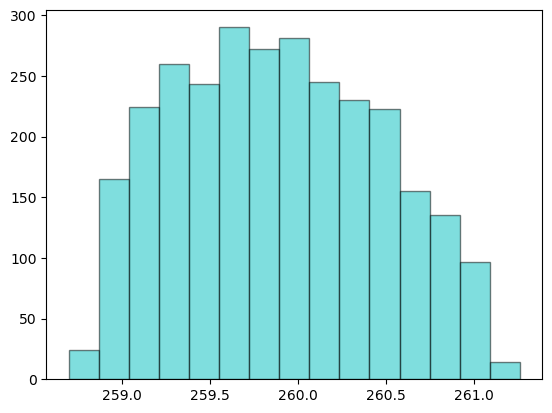

In [62]:
plt.hist(calibrated_data, bins=15, color='c', edgecolor='k', alpha=0.5)

In [65]:
stats.ttest_ind(testing_reference_concentrations, calibrated_data, equal_var=False)

Ttest_indResult(statistic=6.150290212444757, pvalue=8.813211884701735e-10)

In [66]:
stats.ttest_ind(calibrated_data, testing_reference_concentrations, equal_var=False)

Ttest_indResult(statistic=-6.150290212444757, pvalue=8.813211884701735e-10)

In [ ]:

    # CREATING PLOTS
    fig, (ax,ax2) = plt.subplots(1,2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})

    # LEFT PLOT
    ax.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    ax.plot(testing_period,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.55)
    ax.plot(testing_period,calibrated_data,label='Linear calibrated', color='red',linewidth=0.45)

    ax.text(1.35, 1.05, 'Linear r²= '+str(round(model_perf['r2'],2))+' |  m= '+str(round(model_perf['m'],2))+' |  RMSE = '+str(round(model_perf['RMSE'],0)), 
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red', fontsize=8)
    
    ''' for use in creating predictor list in plots '''
    predictor_text = ''
    for predictor in predictors: 
        if predictor != predictors[-1]:
            predictor_text += predictor+' + '
        else: 
            predictor_text += predictor

    ax.text(1.00, -0.25, 'Predictors used = '+predictor_text, horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes, color='red', fontsize=12) 
    
    ax.legend()  
    ax.set_title('Two function TEST -- '+gname+' Regression Calibration Results for July-Nov 2021 (Aug Calibration)', fontsize=10)
    #ax.set_title('New Regression Fx TEST -- '+gname+' Regression Calibration Results for Nov 2021 (Aug Calibration)', fontsize=10)

    ax.set_xlabel('Date')
    #ax.set_xlabel('Day')

    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    ax.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')

    # RIGHT PLOT
    ax2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)

    # 1:1 line
    if var_id==42101: # CO
        xmax = 2000
    if var_id==44201: # O3
        xmax = 200
    if var_id==42601: # NO
        xmax = 200
    if var_id==42602: # N02
        xmax = 70
    if var_id==88101: # pm25
        xmax = 80
    
    ymax=xmax
    point1 = [0,0]
    point2 = [xmax,ymax]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax2.plot(x_values, y_values, color='black', label='1:1 Line')

    ax2.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
    #plt.savefig("/data/shared/ehojeily/calibrate-function-testing/predict_2fx_T_TSQRD_TRH_TVOLT_VOLT_WEEKDAYBIN/"+gname +'_AugCalibration_plt.png', dpi=600)

    ax2.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')